<div class='bar_title'></div>

*Simulation for Decision Making (S4DM)*

# Assignment 5: Input Modeling

Gunther Gust & Ignacio Ubeda <br>
Chair for Enterprise AI <br>
Data Driven Decisions Group <br>
Center for Artificial Intelligence and Data Science (CAIDAS)


<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt

# Agenda

* Fitting a Distribution
* Inverse Transform Method

## Scenario

You have measured customer arrivals at a store that offers food, the store opens at 6:30 in the morning and lunch is offered from 12 noon until 15:30. It is well known that peak demand occurs at lunchtime.

You record the time each customer arrives at the store and collect 100 data points (for simplicity, **assume that all customers arrive individually**). 

The resulting table is stored in `customer_arrivals.csv` and looks like the following:

In [285]:
customer_arrival_df = pd.read_csv('customer_arrivals.csv')

customer_arrival_df.head()

,timestamp
0,06:35:00
1,06:45:49
2,07:00:19
3,07:00:58
4,07:03:20


In [286]:
customer_arrival_df.tail()

,timestamp
95,14:54:40
96,14:58:13
97,15:02:36
98,15:05:41
99,15:10:39


From that, we will compute the *inter-arrival times* (**iat**) which is defined as the time between arrival of customers.

For doing so, we first create a new column `timestamp_dt` to transform the time to a datetime object. 

Then, we substract the time with the time of the previous row (`.shift(1)`) and get the total number of seconds in that timespan (`.dt.total_seconds()`).

In [287]:
#transform string to datetime (HH:MM:SS)
customer_arrival_df['timestamp_dt'] = pd.to_datetime(customer_arrival_df['timestamp'], format='%H:%M:%S')

#compute inter-arrival time (in seconds)
customer_arrival_df['iat'] = (customer_arrival_df['timestamp_dt'] - customer_arrival_df['timestamp_dt'].shift(1) ).dt.total_seconds()

print(customer_arrival_df.shape)
customer_arrival_df.head()

(100, 3)


,timestamp,timestamp_dt,iat
0,06:35:00,1900-01-01 06:35:00,NaN
1,06:45:49,1900-01-01 06:45:49,649.0
2,07:00:19,1900-01-01 07:00:19,870.0
3,07:00:58,1900-01-01 07:00:58,39.0
4,07:03:20,1900-01-01 07:03:20,142.0


Finally, we drop the first row because the **iat** is `NaN`

In [288]:
#drop na
customer_arrival_df = customer_arrival_df.dropna()

print(customer_arrival_df.shape)
customer_arrival_df.head()

(99, 3)


,timestamp,timestamp_dt,iat
1,06:45:49,1900-01-01 06:45:49,649.0
2,07:00:19,1900-01-01 07:00:19,870.0
3,07:00:58,1900-01-01 07:00:58,39.0
4,07:03:20,1900-01-01 07:03:20,142.0
5,07:07:30,1900-01-01 07:07:30,250.0


We'll use this table for the upcoming Tasks

# Exercise / Tasks

**Tasks are independently of each other.**

## Task 1:  Fitting a Distribution

We'd like to fit a probabilistic distribution to our customer arrival dataset. Recall the steps for this procedure:

1. ~~Collect data~~ (**we already did this**)
2. Summarize in a frequency distribution (histogram) to identify the shape of the distribution
3. Identify underlying theoretical probability distribution, or a family of distributions
4. Obtain parameter(s) for the chosen distribution (estimated from the data).
5. Test for fit

-----

**Task 1.1: Create a histogram (or a density plot) for the `iat` column of `customer_arrival_df` DataFrame.**

**Task 1.2: Fit and evaluate (Kolmogorov-Smirnov test) some probabilistic distributions. As a Hint, only test the distributions that are in the `list_of_potential_distributions`. Do you obtain a good fit with them?**

**Task 1.3: Plot the iat column over time. For that, you can use `sns.lineplot(x='x', y='y', data=df)` where `'x'` and `'y'` are the column names present in the `df` DataFrame. What do you see?** 

**Task 1.4: Split the dataset between non-peak and peak demand periods. Fit and evaluate (Kolmogorov-Smirnov test) some probabilistic distributions for each period (again, use only the distributions present in `list_of_potential_distributions`).** 

**Task 1.5: Finally, inspect visually your "best fit" distribution (for each period) with a QQ-plot. Report the selected distribution with its respective parameters.**

-----

**Hint 1:** Recall that lunchtime starts at 12:00:00.

**Hint 2:** For fitting distributions easily, you can use the `.fit()` method for every distribution (`scipy.stats`)

**Hint 3:** If you have several distributions that fit to the data. Select the one with highest pvalue.

In [2]:
list_of_potential_distributions = [stats.expon, stats.norm, stats.uniform, stats.gamma]

<Axes: xlabel='iat', ylabel='Count'>

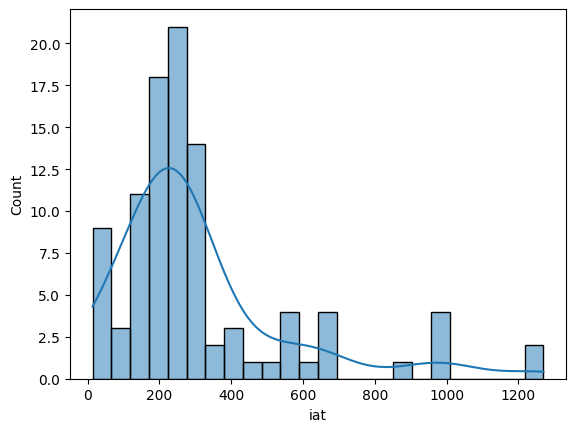

In [6]:
sns.histplot(customer_arrival_df['iat'], kde=True)

In [7]:
significance_level = 0.05

results = {}
for dist in list_of_potential_distributions:

    #fit the data to the distribution, and get the parameters, in this case we're using the maximum likelihood estimation (mle)
    dist_parameters = dist.fit(customer_arrival_df['iat'], method='mle')

    #evaluate with the kolmogorov-smirnov test
    test_result = stats.kstest(customer_arrival_df['iat'], dist.name, args=dist_parameters)

    #save the test results and the parameters
    results[dist.name] = {'test': test_result, 'params': dist_parameters}

    if test_result.pvalue < significance_level:
        print(f'{dist.name} is a "poor" fit')
    else:
        print(f'{dist.name} is a "good" fit')

expon is a "poor" fit
norm is a "poor" fit
uniform is a "poor" fit
gamma is a "poor" fit


Answer the following questions:

- Is there any distribution that have a good fit to this dataset?

**Answer in this markdown chunk:**

- *Your answer here* (**Answer:** No. All distributions tested fit poorly to the data set. We then plot the interarrival times over time)

([], [])

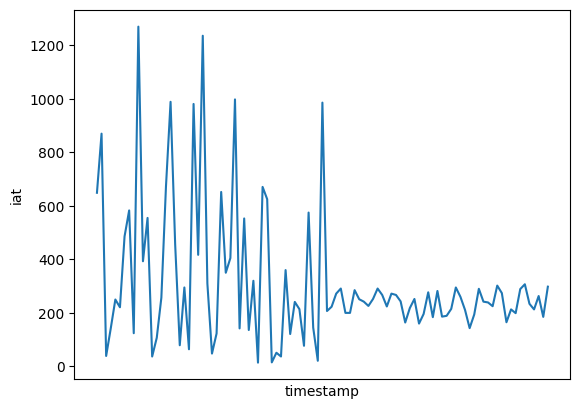

In [289]:
sns.lineplot(x='timestamp', y='iat', data=customer_arrival_df)
plt.xticks([])

Answer the following questions:

- Is there any particular pattern that you can see?

**Answer in this markdown chunk:**

- *Your answer here* (
    **Answer:**

There is one point (of time) where the inter-arrival times changes drastically. This may be due the high demand period starts at 12:00:00. 

Therefore the distribution of the inter-arrival times changes between non-peak and peak demand period!

Let's confirm that showing the change when the peak demand period starts. First let's get the row index when this happens (nearest to 12:00:00)


)

In [9]:
customer_arrival_df[:60]

,timestamp,timestamp_dt,iat
1,06:45:49,1900-01-01 06:45:49,649.0
2,07:00:19,1900-01-01 07:00:19,870.0
3,07:00:58,1900-01-01 07:00:58,39.0
4,07:03:20,1900-01-01 07:03:20,142.0
5,07:07:30,1900-01-01 07:07:30,250.0
6,07:11:11,1900-01-01 07:11:11,221.0
7,07:19:17,1900-01-01 07:19:17,486.0
8,07:29:00,1900-01-01 07:29:00,583.0
9,07:31:04,1900-01-01 07:31:04,124.0
10,07:52:14,1900-01-01 07:52:14,1270.0


The nearest row index to 12:00:00 is 51 (or 50 too). Let's plot the inter-arrival times over time with a vertical line in this point of time.

([], [])

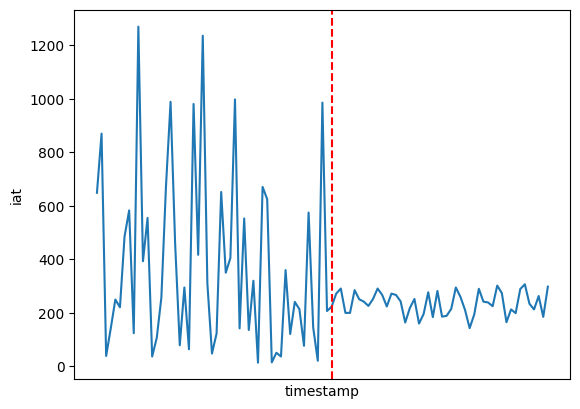

In [10]:
sns.lineplot(x='timestamp', y='iat', data=customer_arrival_df)
plt.axvline(x=51, color='r', linestyle='--')
plt.xticks([])

With this plot is even clearer that we have two different distributions in this dataset. We'll split the dataset into 2 (non-peak and peak demand) periods and try different distributions for each of them.

In [11]:
customer_arrival_df_nonpeak = customer_arrival_df[customer_arrival_df.index < 51]

print(customer_arrival_df_nonpeak.shape)
customer_arrival_df_nonpeak.head()

(50, 3)


,timestamp,timestamp_dt,iat
1,06:45:49,1900-01-01 06:45:49,649.0
2,07:00:19,1900-01-01 07:00:19,870.0
3,07:00:58,1900-01-01 07:00:58,39.0
4,07:03:20,1900-01-01 07:03:20,142.0
5,07:07:30,1900-01-01 07:07:30,250.0


In [12]:
customer_arrival_df_peak = customer_arrival_df[customer_arrival_df.index >= 51]

print(customer_arrival_df_peak.shape)
customer_arrival_df_peak.head()

(49, 3)


,timestamp,timestamp_dt,iat
51,12:01:09,1900-01-01 12:01:09,207.0
52,12:04:52,1900-01-01 12:04:52,223.0
53,12:09:24,1900-01-01 12:09:24,272.0
54,12:14:15,1900-01-01 12:14:15,291.0
55,12:17:35,1900-01-01 12:17:35,200.0


#### Non peak demand

([], [])

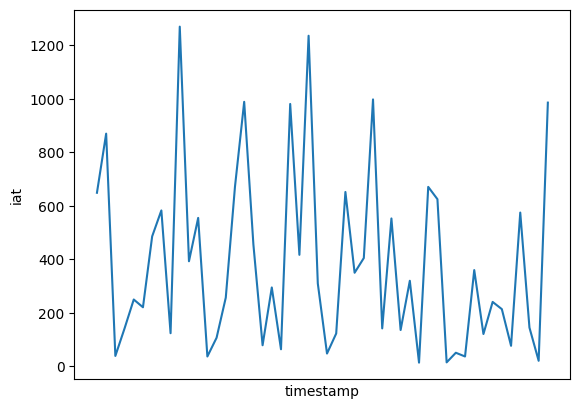

In [13]:
sns.lineplot(x='timestamp', y='iat', data=customer_arrival_df_nonpeak)
plt.xticks([])

<Axes: xlabel='iat', ylabel='Count'>

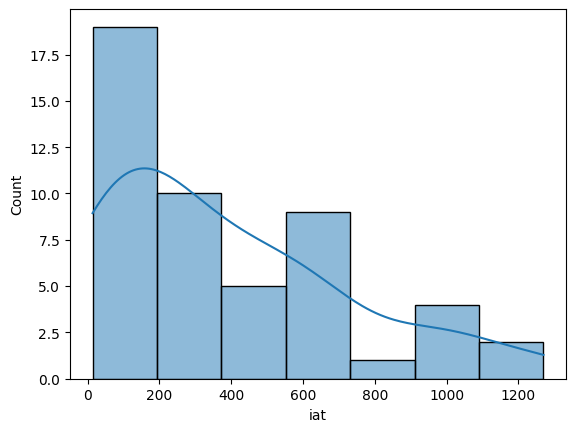

In [14]:
sns.histplot(customer_arrival_df_nonpeak['iat'], kde=True)

In [15]:
significance_level = 0.05

results_nonpeak = {}
for dist in list_of_potential_distributions:

    #fit the data to the distribution, and get the parameters, in this case we're using the maximum likelihood estimation (mle)
    dist_parameters = dist.fit(customer_arrival_df_nonpeak['iat'], method='mle')

    #evaluate with the kolmogorov-smirnov test
    test_result = stats.kstest(customer_arrival_df_nonpeak['iat'], dist.name, args=dist_parameters)

    #save the test results and the parameters
    results_nonpeak[dist.name] = {'test': test_result, 'params': dist_parameters}

    if test_result.pvalue < significance_level:
        print(f'{dist.name} is a "poor" fit')
    else:
        print(f'{dist.name} is a "good" fit')

expon is a "good" fit
norm is a "good" fit
uniform is a "poor" fit
gamma is a "good" fit


In [16]:
results_nonpeak

{'expon': {'test': KstestResult(statistic=0.08404425854633824, pvalue=0.8426029928614678, statistic_location=553.0, statistic_sign=-1),
  'params': (14.0, 373.24)},
 'norm': {'test': KstestResult(statistic=0.144435104203668, pvalue=0.22506228797852057, statistic_location=145.0, statistic_sign=1),
  'params': (387.24, 336.14470455445223)},
 'uniform': {'test': KstestResult(statistic=0.3361146496815286, pvalue=1.5352248651984644e-05, statistic_location=672.0, statistic_sign=1),
  'params': (14.0, 1256.0)},
 'gamma': {'test': KstestResult(statistic=0.12566365714104621, pvalue=0.3772176758897421, statistic_location=214.0, statistic_sign=-1),
  'params': (0.6893401295587338, 13.999999999999998, 492.7202807644277)}}

We have several candidates, but the distribution with highest pvalue is the exponential distribution (pvalue = 0.843). So we'll select this one for visual inspection

Note that the parameters retrieve by the `.dist` method for the exponential distribution are (*loc*, *scale*) = (14.0, 373.24) 

However in `numpy` we can only set the *scale* parameter (because of the parametrization). Therefore we have to force the *loc* parameter to be zero in the fitting procedure. We can do this by using the `f` keyword in the `.dist` method.

**Keep in mind the distribution parametrization used in `scipy` and the one used in `numpy`. We'll use `scipy` for fitting the distribution parameters but then, we'll use them in `numpy` for sampling from the fitted distribution and thus they have to be "synchronized".** 

In [17]:
best_dist = stats.expon

#fit the exponential distribution but force the location parameter to be 0 (floc=0)
best_dist_parameters = best_dist.fit(customer_arrival_df_nonpeak['iat'], method='mle', floc=0)

#evaluate with the kolmogorov-smirnov test
test_result = stats.kstest(customer_arrival_df_nonpeak['iat'], best_dist.name, args=best_dist_parameters)

print(best_dist_parameters)
print(test_result)

(0.0, 387.24)
KstestResult(statistic=0.080225157683805, pvalue=0.8788333303529227, statistic_location=553.0, statistic_sign=-1)


Forcing the *loc* to be equal to 0, we haven't decrease the pvalue. Therefore we can follow with the visual inspection:

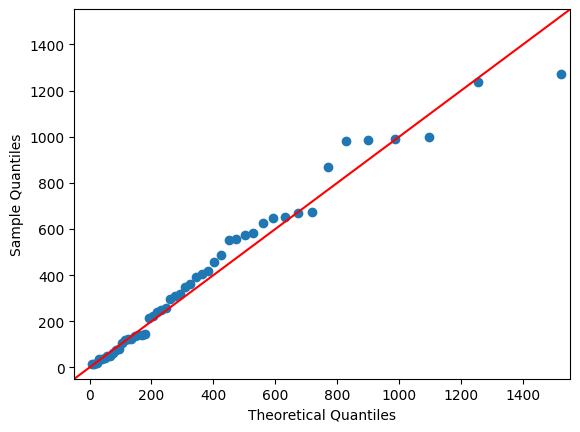

In [18]:
res = sm.qqplot(customer_arrival_df_nonpeak['iat'], dist=best_dist, line ='45', loc = best_dist_parameters[0], scale = best_dist_parameters[1]) 

The QQ-plot looks Ok. We select the exponential distribution for the non-peak inter-arrival times with the following fitted parameters:

In [19]:
best_dist_parameters

(0.0, 387.24)

#### Peak demand

([], [])

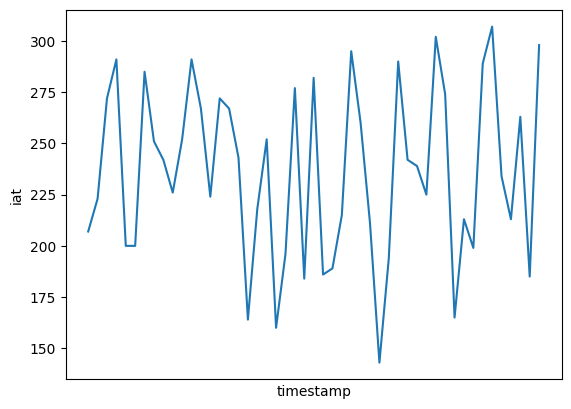

In [20]:
sns.lineplot(x='timestamp', y='iat', data=customer_arrival_df_peak)
plt.xticks([])

<Axes: xlabel='iat', ylabel='Count'>

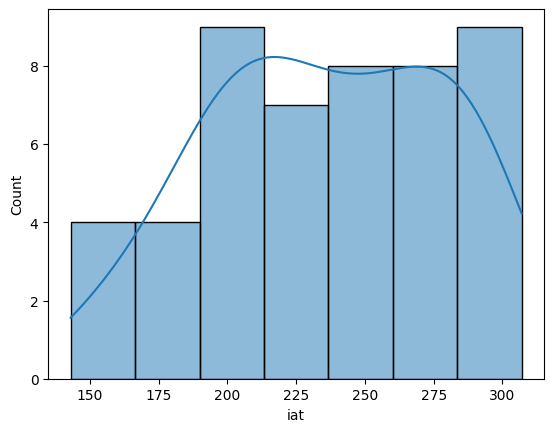

In [21]:
sns.histplot(customer_arrival_df_peak['iat'], kde=True)

In [22]:
significance_level = 0.05

results_peak = {}
for dist in list_of_potential_distributions:

    #fit the data to the distribution, and get the parameters, in this case we're using the maximum likelihood estimation (mle)
    dist_parameters = dist.fit(customer_arrival_df_peak['iat'], method='mle')

    #evaluate with the kolmogorov-smirnov test
    test_result = stats.kstest(customer_arrival_df_peak['iat'], dist.name, args=dist_parameters)

    #save the test results and the parameters
    results_peak[dist.name] = {'test': test_result, 'params': dist_parameters}

    if test_result.pvalue < significance_level:
        print(f'{dist.name} is a "poor" fit')
    else:
        print(f'{dist.name} is a "good" fit')

expon is a "poor" fit
norm is a "good" fit
uniform is a "good" fit
gamma is a "good" fit


In [23]:
results_peak

{'expon': {'test': KstestResult(statistic=0.2740772072802124, pvalue=0.0009602825336618714, statistic_location=184.0, statistic_sign=-1),
  'params': (143.0, 93.26530612244898)},
 'norm': {'test': KstestResult(statistic=0.09157805474486869, pvalue=0.7715558501034626, statistic_location=267.0, statistic_sign=-1),
  'params': (236.26530612244898, 42.531513171546)},
 'uniform': {'test': KstestResult(statistic=0.16836734693877553, pvalue=0.1104710716109476, statistic_location=184.0, statistic_sign=-1),
  'params': (143.0, 164.0)},
 'gamma': {'test': KstestResult(statistic=0.092381809724848, pvalue=0.7625331553584792, statistic_location=267.0, statistic_sign=-1),
  'params': (406.445365937627, -626.557344168165, 2.122956373869746)}}

We have several candidates, but the distribution with highest pvalue is the normal distribution (pvalue = 0.772). So we'll select this one for visual inspection

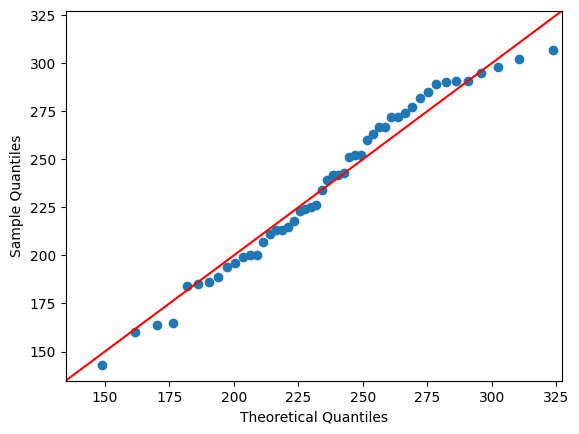

In [24]:
res = sm.qqplot(customer_arrival_df_peak['iat'], dist=stats.norm, line ='45', 
                loc = results_peak['norm']['params'][0], scale = results_peak['norm']['params'][1]) 

The QQ-plot looks Ok. We select the normal distribution for the peak inter-arrival times with the following fitted parameters:

In [25]:
results_peak['norm']['params']

(236.26530612244898, 42.531513171546)

**Note that since we can set both the *loc* and *scale* parameters for the normal distribution in `numpy`, we don't have to force anything in the fitting procedure (as with the exponential distribution), and we can use the found parameters directly**

Answer the following questions:

1. Which distribution best fits to the non-peak demand period? What are the parameters of the distribution?
1. Which distribution best fits to the peak demand period? What are the parameters of the distribution?

**Answer in this markdown chunk:**

1. *Your answer here* (**Answer:** Exponential distribution (pvalue=0.88) - loc = 0.0, scale (1/lambda)= 387.24)
1. *Your answer here* (**Answer:** Normal distribution (pvalue=0.77) - loc (mu) = 236.27, scale (sigma) = 42.53) 

## Task 2:  Inverse Transform Method (Empirical CDF)

We'd like to sample using the empirical CDF of our customer arrival dataset. For that, we'll implement the Inverse Transform Method.

-----

**Task 2.1: Create a histogram (or a density plot) for the `iat` column of `customer_arrival_df` DataFrame.**

**Task 2.2: Count the number of ocurrences of the `iat` values in different intervals. This can be easily done with the `np.histogram()` function. Check the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) to understand how it works. Note that the function return two values: `hist` and `bin_edges` and that the number of bins (intervals) is a parameter you've to choose.**

Using the above function we've created (for you) a DataFrame called `empirical_cdf_df` which have 3 columns: 
- `interval_lb`: the lower bound of the interval
- `interval_ub`: the upper bound of the interval
- `freq`: the number of ocurrences of `iat` values that are present in the interval (i.e. the frequency of observations)

With 8 intervals, the table should look like this:

<img src="images/assignment5_empirical_cdf.png" style="width:20%" />

This means that there are 23 observations of the `iat` values in the [14.0, 171.0] interval, 53 in [171.0, 328.0], and so on.

The DataFrame is still not entirely complete, we'd like to create a table that looks like this (from the lecture):

<img src="images/assignment5_empirical_cdf_lecture.png" style="width:50%" />

**Task 2.3: Create 3 more columns to `empirical_cdf_df`:**
- **`relative_freq`: relative frequency (i.e. frequency divided by the total number of observations)**
- **`cumulative_freq`: Cumulative sum of the relative frequency column. The last row of this column should be 1.0**
- **`slope`: The slope for the interval. This is defined as the upper bound minus the lower bound and this result divided by the probability of being in that interval. What is this probability?**

Now we have our Empirical CDF table ready to implement the Inverse Transform Method. Check the following example of how is computed using the table from the lecture:

<img src="images/assignment5_empirical_itm_lecture.png" style="width:50%" />

The procedure should receive a random number between 0 and 1 ($R=0.83$ in the example) and, using the Empirical CDF, return a (sampled) value ($X=1.75$ in the example).

**Task 2.4: Compute the following variables of the method:**
- **$i$: the index of the row where R falls. In the lecture example ($R=0.83$), $i=4$ (i.e. the 4th row). You may want to use the function `np.where` for this. Recall that indexes in python start at 0.**
- **$x$: the lower bound of the interval where R falls. In the lecture example ($R=0.83$), $x=1.5$.**
- **$a$: the slope of the interval where R falls. In the lecture example ($R=0.83$), $a=1.47$.**
- **$c$: the cumulative frequency of the previous interval where R falls. In the lecture example ($R=0.83$), $c=0.66$. Take special consideration in the case where $i=0$, what value should take this variable in this case?**
- **$X$: the resulting (sampled) value. In the lecture example ($R=0.83$), $X=1.75$**

**Task 2.5: Now that you have computed everything for one particular $R$, pack the implementation in a function: `inverse_transform_sampling`**

Finally, use the function `inverse_transform_sampling` for sampling from the Empirical CDF. Check how the (sampled) distribution looks like and compare it with the original histogram of Task 2.1 (we provide this last code for you, you don't have to code anything). 

If you want, check how the results change with different sample sizes and with different number of bins (for creating the Empirical CDF)

-----

**Hint: You may want to use the `.iloc[]` method for selecting rows by index in a DataFrame. For example, if you want to select the value of the column `c1` in the 5th row of a DataFrame, `df`, this is the syntax: `df.iloc[4]['c1']` (rembember, indexes start at 0 in python)**

<Axes: xlabel='iat', ylabel='Count'>

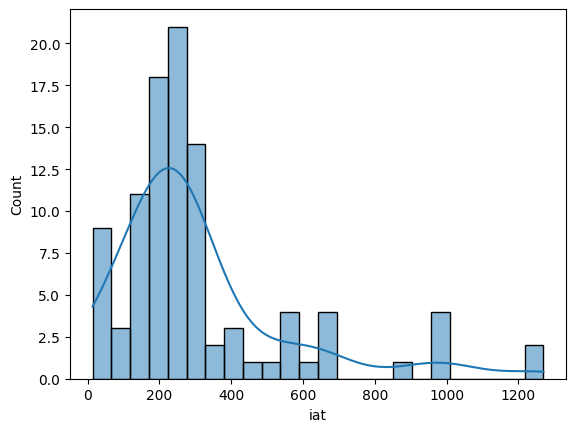

In [249]:
sns.histplot(customer_arrival_df['iat'], kde=True)

In [311]:
n_bins = 8

hist, bin_edges = np.histogram(customer_arrival_df['iat'], bins = n_bins, density=False)

print(len(bin_edges))
print(bin_edges)
print(len(hist))
print(hist)

9
[  14.  171.  328.  485.  642.  799.  956. 1113. 1270.]
8
[23 53  6  6  4  1  4  2]


In [296]:
empirical_cdf_df = pd.DataFrame({'interval_lb': bin_edges[:-1], #lower bound
                                 'interval_ub': bin_edges[1:], #upper bound
                                 'freq': hist}) #frequency of observations

empirical_cdf_df

,interval_lb,interval_ub,freq
0,14.0,171.0,23
1,171.0,328.0,53
2,328.0,485.0,6
3,485.0,642.0,6
4,642.0,799.0,4
5,799.0,956.0,1
6,956.0,1113.0,4
7,1113.0,1270.0,2


In [298]:
#compute the relative frequency
empirical_cdf_df['relative_freq'] = empirical_cdf_df['freq'] / empirical_cdf_df['freq'].sum()

#compute the cumulative frequency
empirical_cdf_df['cumulative_freq'] = empirical_cdf_df['relative_freq'].cumsum()

#compute slope
empirical_cdf_df['slope'] = (empirical_cdf_df['interval_ub'] - empirical_cdf_df['interval_lb']) / empirical_cdf_df['relative_freq']

empirical_cdf_df

,interval_lb,interval_ub,freq,relative_freq,cumulative_freq,slope
0,14.0,171.0,23,0.232323,0.232323,675.782609
1,171.0,328.0,53,0.535354,0.767677,293.264151
2,328.0,485.0,6,0.060606,0.828283,2590.500000
3,485.0,642.0,6,0.060606,0.888889,2590.500000
4,642.0,799.0,4,0.040404,0.929293,3885.750000
5,799.0,956.0,1,0.010101,0.939394,15543.000000
6,956.0,1113.0,4,0.040404,0.979798,3885.750000
7,1113.0,1270.0,2,0.020202,1.000000,7771.500000


In [282]:
R = np.random.uniform(0, 1)
print(R)
print(f"R: {R}")

print(R <= empirical_cdf_df['cumulative_freq'])

i = np.where(R <= empirical_cdf_df['cumulative_freq'])[0].min()

print(f"i: {i}")

x = empirical_cdf_df.iloc[i]['interval_lb']

print(f"x: {x}")

a = empirical_cdf_df.iloc[i]['slope']

print(f"a: {a}")

c = empirical_cdf_df.iloc[i-1]['cumulative_freq'] if i > 0 else 0

print(f"c: {c}")

X = x + a * (R - c)

print(f"X: {X}")

0.8092703023805439
R: 0.8092703023805439
0    False
1    False
2     True
3     True
4     True
5     True
6     True
7     True
Name: cumulative_freq, dtype: bool
i: 2
x: 328.0
a: 2590.5
c: 0.7676767676767677
X: 435.7480516501321


Once we've implemented the method for one $R$, let's pack the implementation in a function:

In [299]:
def inverse_transform_sampling(empirical_cdf_df):
    R = np.random.uniform(0, 1)
    i = np.where(R <= empirical_cdf_df['cumulative_freq'])[0].min()
    x = empirical_cdf_df.iloc[i]['interval_lb']
    a = empirical_cdf_df.iloc[i]['slope']
    c = empirical_cdf_df.iloc[i-1]['cumulative_freq'] if i > 0 else 0
    X = x + a * (R - c)
    return X

Finally, we'll use the function for sampling from the Empirical CDF:

<Axes: ylabel='Count'>

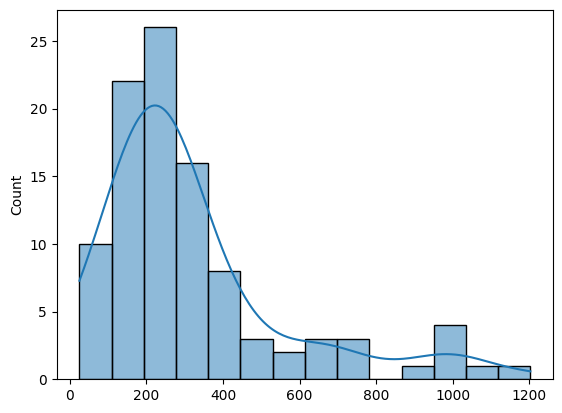

In [338]:
#Empirical CDF sampling

n_samples = 100
data = []

for i in range(n_samples):
    data.append(inverse_transform_sampling(empirical_cdf_df))

sns.histplot(data, kde=True)

## Task 3:  Final Project Description 

We'd like you start thinking of the final project. Therefore we ask you to answer the following questions:

1. What system would you like to analyze? Describe the system in terms of entity(ies), resource(s) and process(es) and how they interact with each other.
1. What (input) measurements do you need to calibrate the system? How would you collect them?
1. What (output) measurements do you need to calibrate the system? How would you collect them?
1. What output measurement(s) would you like to evaluate and optimize?

Is not mandatory but if you want you can support your description with a flow diagram.

**Answer in this markdown chunk:**